In [1]:
import pandas as pd
import numpy as np
import jinja2
from sklearn import tree
from sklearn.preprocessing import scale as scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# keras specific
from keras.models import Sequential
from keras.layers import Dense
from tensorflow import keras
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.utils import to_categorical

# poisson
from scipy.stats import poisson

In [2]:
# Ensemble learning imports

from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

## Data preperation and knowledge

In [3]:
# read the csv file
match_data_unfiltered = pd.read_csv("Data\\preprocessed_dataframe_with_elo_mw_form_final_version.csv")
pd.set_option('mode.chained_assignment', None)

In [4]:
# make FTR column to continous variable
def convert_ftr(result: str):
    if result == "D":
        return 1
    elif result == "H":
        return 2
    elif result == "A":
        return 0
    else: 
        return None
match_data_unfiltered['FTR'] = match_data_unfiltered['FTR'].apply(convert_ftr)
match_data_unfiltered = match_data_unfiltered.drop(["Unnamed: 0"], axis=1, errors="ignore")

In [5]:
# print correlation matrix
correlation_matrix_match_data_unfiltered = match_data_unfiltered.corr()[['FTR', 'FTHG', 'FTAG']]
correlation_matrix_match_data_unfiltered = correlation_matrix_match_data_unfiltered.dropna()
correlation_matrix_match_data_unfiltered = correlation_matrix_match_data_unfiltered.iloc[6:].T
correlation_matrix_match_data_unfiltered.style.background_gradient()

,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,PointsLast3MatchesHT,PointsLast3MatchesAT,PointsLast5MatchesHT,PointsLast5MatchesAT,PointsLast10MatchesHT,PointsLast10MatchesAT,PointsLastAllMatchesHT,PointsLastAllMatchesAT,PDiff3Matches,PQuot3Matches,PDiff5Matches,PQuot5Matches,PDiff10Matches,PQuot10Matches,PDiffAllMatches,PQuotAllMatches,MarketValueHT,MarketValueAT,MarketValueDiff,MarketValueQuot,HomeElo,AwayElo,HomeAttack,HomeDefend,AwayAttack,AwayDefend,HomeEloOld,AwayEloOld,HomeAttackOld,HomeDefendOld,AwayAttackOld,AwayDefendOld,DiffEloOld,DiffAttackOld,DiffDefendOld,DiffElo,DiffAttack,DiffDefend,QuotEloOld,QuotAttackOld,QuotDefendOld,QuotElo,QuotAttack,QuotDefend,DirectComparisonHG,DirectComparisonAG,DirectComparisonGoalDiff,DirectComparisonGoalQuot
FTR,-0.207768,0.386246,-0.400161,-0.048700,0.004190,0.008473,-0.049340,-0.121265,0.052348,-0.136436,0.089823,0.145681,-0.106607,0.175385,-0.140737,0.218937,-0.171125,0.113177,-0.098790,0.179660,0.128351,0.226256,0.149288,0.282227,0.194064,0.275055,0.173635,0.188790,-0.228257,0.311574,0.233787,0.140194,-0.163084,0.541096,0.533376,-0.495043,-0.509603,0.103194,-0.126161,0.178605,0.106706,-0.153297,-0.095934,0.272295,0.234319,0.144148,0.365008,0.701809,0.702978,0.256915,-0.019285,0.003690,0.350101,0.028750,-0.031486,0.193246,-0.187042,0.242784,0.176735
FTHG,-0.127921,0.585234,-0.128724,-0.112605,-0.076080,0.038874,-0.076387,-0.133392,0.016655,-0.083056,0.059849,0.156280,-0.081358,0.188137,-0.102868,0.231550,-0.117648,0.132921,-0.063668,0.168858,0.120108,0.208027,0.127957,0.252656,0.176465,0.255204,0.176207,0.281683,-0.139178,0.314423,0.259012,0.190224,-0.090148,0.820345,0.140157,-0.131100,-0.766525,0.161991,-0.062345,0.213552,0.102074,-0.093717,-0.085480,0.266457,0.214220,0.133405,0.337465,0.666234,0.614170,0.251201,0.009119,-0.014006,0.324073,0.018587,-0.029202,0.245613,-0.161368,0.258620,0.231053
FTAG,0.301151,-0.126841,0.569383,-0.006126,-0.051864,-0.049845,0.067192,0.096068,-0.054771,0.138264,-0.060353,-0.084122,0.119331,-0.105000,0.153898,-0.128483,0.197988,-0.067073,0.110251,-0.145529,-0.111976,-0.185665,-0.129811,-0.236222,-0.151564,-0.230000,-0.137569,-0.097012,0.247817,-0.257620,-0.169223,-0.051194,0.184719,-0.129224,-0.766175,0.718937,0.134413,-0.027467,0.160728,-0.093258,-0.065222,0.167660,0.085786,-0.223315,-0.186854,-0.107470,-0.283909,-0.553353,-0.604116,-0.210258,0.012920,-0.021655,-0.270089,-0.026470,0.011304,-0.116835,0.183342,-0.192749,-0.128752


In [6]:
# filter for specific columns
match_data_reduced = match_data_unfiltered.loc[:, ["FTR", "FTHG", "FTAG", "HomeEloOld", "AwayEloOld", "DiffEloOld", "HomeAttackOld", "HomeDefendOld", 
"AwayAttackOld", "AwayDefendOld", "DiffDefendOld", "DiffAttackOld", "MarketValueDiff", "PDiff3Matches", 'PDiffAllMatches', 
'PQuotAllMatches', 'DirectComparisonGoalDiff', 'DirectComparisonGoalQuot', 'DirectComparisonHG', 'DirectComparisonAG']]
correlation_matrix_match_data_reduced = match_data_reduced.corr()[['FTR', 'FTHG', 'FTAG']].iloc[3:].T
correlation_matrix_match_data_reduced.style.background_gradient()

,HomeEloOld,AwayEloOld,DiffEloOld,HomeAttackOld,HomeDefendOld,AwayAttackOld,AwayDefendOld,DiffDefendOld,DiffAttackOld,MarketValueDiff,PDiff3Matches,PDiffAllMatches,PQuotAllMatches,DirectComparisonGoalDiff,DirectComparisonGoalQuot,DirectComparisonHG,DirectComparisonAG
FTR,0.103194,-0.126161,0.272295,0.178605,0.106706,-0.153297,-0.095934,0.144148,0.234319,0.311574,0.179660,0.275055,0.173635,0.242784,0.176735,0.193246,-0.187042
FTHG,0.161991,-0.062345,0.266457,0.213552,0.102074,-0.093717,-0.085480,0.133405,0.214220,0.314423,0.168858,0.255204,0.176207,0.258620,0.231053,0.245613,-0.161368
FTAG,-0.027467,0.160728,-0.223315,-0.093258,-0.065222,0.167660,0.085786,-0.107470,-0.186854,-0.257620,-0.145529,-0.230000,-0.137569,-0.192749,-0.128752,-0.116835,0.183342


In [7]:
# focus on best Features
correlation_matrix_match_data_reduced = correlation_matrix_match_data_reduced.loc[:, [
    "DiffEloOld", "DiffDefendOld", "DiffAttackOld", "MarketValueDiff", "PDiff3Matches", "DirectComparisonGoalDiff", "PDiffAllMatches"]]
correlation_matrix_match_data_reduced.style.background_gradient()

,DiffEloOld,DiffDefendOld,DiffAttackOld,MarketValueDiff,PDiff3Matches,DirectComparisonGoalDiff,PDiffAllMatches
FTR,0.272295,0.144148,0.234319,0.311574,0.179660,0.242784,0.275055
FTHG,0.266457,0.133405,0.214220,0.314423,0.168858,0.258620,0.255204
FTAG,-0.223315,-0.107470,-0.186854,-0.257620,-0.145529,-0.192749,-0.230000


In [8]:
match_data_bl = match_data_unfiltered.copy(deep=True)

In [9]:
# split data to train/test and X/y
features = ["DiffEloOld", "DiffAttackOld", "DiffDefendOld", "PDiff3Matches", "PDiff10Matches", "PQuotAllMatches", 
            "MarketValueDiff", "DirectComparisonHG", "DirectComparisonAG"]
match_data_bl_wo_nan = match_data_bl.dropna(subset=features)
X = match_data_bl_wo_nan.loc[:, features]
y = match_data_bl_wo_nan.loc[:, ["FTR"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [10]:
# scale data
X_scaled = scale(X)

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=42)

## Mathematical Approach

In [11]:
# copy initial df for mathematical approach
match_data_all_bundesliga = match_data_unfiltered.copy(deep=True)
# convert string date to pandas datetime
match_data_all_bundesliga['Date'] = pd.to_datetime(match_data_all_bundesliga['Date'], dayfirst=True)
# split bl dataframe to test (last 5 years bevor this season) and train (last season)
df_bl_test_whole_saison = match_data_all_bundesliga[match_data_all_bundesliga['Date'] > pd.to_datetime('2021-06-30')]
df_bl_test_season_partly = match_data_all_bundesliga[match_data_all_bundesliga['Date'] > pd.to_datetime('2021-11-30')]
match_data_bl_past_5_years = match_data_all_bundesliga[(match_data_all_bundesliga.Date < pd.to_datetime('2021-11-30'))&(match_data_all_bundesliga.Date > pd.to_datetime('2015-06-30'))]
match_data_bl_test = match_data_all_bundesliga[(match_data_all_bundesliga.Date < pd.to_datetime('2021-06-30'))]

In [12]:
# get array with goals scored in direct comparison
history_pair_h = match_data_bl_past_5_years.groupby(['HomeTeam', 'AwayTeam'])
ave_home_scored = history_pair_h['FTHG'].mean()
history_pair_a = match_data_bl_past_5_years.groupby(['AwayTeam', 'HomeTeam'])
ave_away_scored = history_pair_a['FTAG'].mean()

In [13]:
home_goals_av = np.ones(100)
away_goals_av = np.ones(100)

for i in range(len(match_data_unfiltered)-1000):
    counter = i + 1000
    home_team = match_data_unfiltered['HomeTeam'].iloc[counter]
    away_team = match_data_unfiltered['AwayTeam'].iloc[counter]

In [14]:
# predict with the possion distribution which team will win 
def get_score(home, away, number_of_simulations):
    result = []
    try:
        ave_h_scored = ave_home_scored.loc[home, away]#, ave_away_scored.loc(away)}
        ave_a_scored = ave_away_scored.loc[away, home]
        # if the teams already played against each other it uses the last games goal distribution 
        # to predict the result for the pending game
        for i in range(number_of_simulations):
            h_scored = poisson.rvs(1, ave_h_scored)
            a_scored = poisson.rvs(1, ave_a_scored)
            result.append([h_scored, a_scored])
        return result

    except:
        t_ave_h_scored = ave_home_scored.loc[home].mean()
        t_ave_h_conceded = ave_away_scored.loc[:, home].mean()
        t_ave_a_scored = ave_away_scored.loc[away].mean()
        t_ave_a_conceded = ave_home_scored.loc[:, away].mean()

        for i in range(number_of_simulations):
            h_scored = poisson.rvs(1, (t_ave_h_scored+t_ave_a_conceded)/2)
            a_scored = poisson.rvs(1, (t_ave_a_scored+t_ave_h_conceded)/2)
            result.append([h_scored, a_scored])
        return result

In [15]:
# simulate one single match x times and predict result for it
alpha = 0.025
number_of_repetitions = 1000

def get_result_for_one_single_match(home_team, away_team):
    result = []
    x = get_score(home_team, away_team, number_of_repetitions)
    for i in x:
        if i[0] > i[1]:
            result.append(2)
        elif i[0] == i[1]:
            result.append(1)
        else:
            result.append(0)
    home_win = result.count(2)/len(result)
    away_win = result.count(0)/len(result)
    draw = result.count(1)/len(result)
    # print(f"Probability for home win: {home_win}, Away_win: {away_win}, draw: {draw}, Teams: {home_team, away_team}")
    return 2 if home_win > away_win and home_win > (draw+alpha) else 0 if away_win > (draw+alpha) else 1 

In [16]:
# simulate poisson regression for all games
df_bl_test_season_partly['PredictedResult'] = None
for i in df_bl_test_season_partly.index:
    home_team = df_bl_test_season_partly.loc[i, 'HomeTeam']
    away_team = df_bl_test_season_partly.loc[i, 'AwayTeam']
    df_bl_test_season_partly.loc[i, 'PredictedResult'] = get_result_for_one_single_match(home_team, away_team)

In [17]:
# get accuracy
acc = len(df_bl_test_season_partly[df_bl_test_season_partly['FTR']==df_bl_test_season_partly['PredictedResult']])/\
      len(df_bl_test_season_partly)
print(f"Accuracy of mathematical approach is: {round(acc, 2)}%")

Accuracy of mathematical approach is: 0.43%


In [18]:
# get actual number of home wins, draws and away wins 
df_bl_test_season_partly['FTR'].value_counts()

2    84
0    60
1    45
Name: FTR, dtype: int64

In [19]:
# get predicted number of home wins, draws and away wins 
df_bl_test_season_partly['PredictedResult'].value_counts()

2    102
0     72
1     15
Name: PredictedResult, dtype: int64

## Train Decision Tree Classifier as first Model

In [20]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [21]:
clf_scaled = tree.DecisionTreeClassifier()
clf_scaled = clf_scaled.fit(X_train_scaled, y_train)

In [22]:
clf.predict(X_test)

array([2, 2, 2, ..., 0, 2, 1], dtype=int64)

In [23]:
clf_scaled.predict(X_test_scaled)

array([2, 2, 2, ..., 0, 2, 0], dtype=int64)

In [24]:
result = clf.score(X_test, y_test)
result_scaled = clf_scaled.score(X_test_scaled, y_test)

In [25]:
result

0.3644859813084112

In [26]:
result_scaled

0.3728971962616822

Confusion matrix, without normalization
[[114  86 128]
 [ 81  58 118]
 [142 125 218]]
Normalized confusion matrix
[[0.34756098 0.26219512 0.3902439 ]
 [0.3151751  0.22568093 0.45914397]
 [0.29278351 0.25773196 0.44948454]]


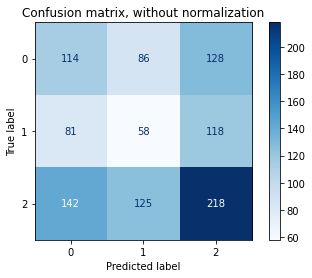

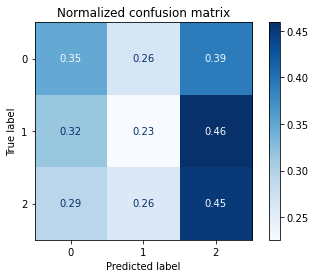

In [27]:
class_names = {
    'Away'
    ,'Draw',
    'Home'
}
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        #display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## Ensemble Learning

In [28]:
# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['lda'] = LinearDiscriminantAnalysis()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    return models

In [29]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
    scores = cross_val_score(model,
                             X,
                             y,
                             scoring='accuracy',
                             cv=cv,
                             n_jobs=-1,
                             error_score='raise')
    return scores

>lr 0.513 (0.014)
>lda 0.510 (0.015)
>knn 0.419 (0.015)
>cart 0.397 (0.017)
>svm 0.507 (0.013)
>bayes 0.476 (0.019)


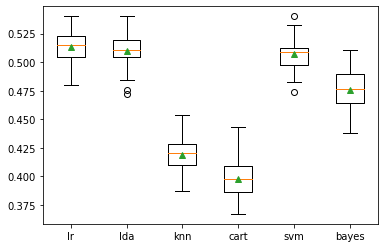

In [30]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>lr 0.510 (0.014)
>lda 0.510 (0.015)
>knn 0.422 (0.015)
>cart 0.399 (0.019)
>svm 0.510 (0.014)
>bayes 0.476 (0.019)


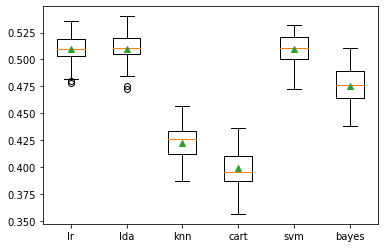

In [31]:
# scaled X

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_scaled, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

### Stack the single models to a combination

In [32]:
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lr', LogisticRegression()))
    level0.append(('lda', LinearDiscriminantAnalysis()))
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('cart', DecisionTreeClassifier()))
    level0.append(('svm', SVC()))
    level0.append(('bayes', GaussianNB()))
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model


In [33]:
# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['lda'] = LinearDiscriminantAnalysis()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    models['stacking'] = get_stacking()
    return models


>lr 0.513 (0.014)
>lda 0.510 (0.015)
>knn 0.419 (0.015)
>cart 0.397 (0.018)
>svm 0.507 (0.013)
>bayes 0.476 (0.019)
>stacking 0.510 (0.016)


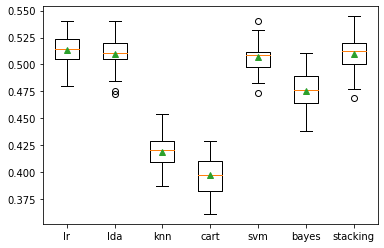

In [34]:
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## Neural Network

### Functions for first Neural Network

In [35]:
def one_hot_encode_outputs(y_train, y_test):
    # one hot encode outputs
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    return y_train, y_test

In [36]:
def train_model(X_train, y_train, number_of_epochs=20):
    model = Sequential()
    model.add(Dense(500, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    # build the model
    history = model.fit(X_train, y_train, epochs=number_of_epochs)
    return history, model

In [37]:
def print_accuracy(X_train, y_train, X_test, y_test, model):
    pred_train= model.predict(X_train)
    scores = model.evaluate(X_train, y_train, verbose=0)
    print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
    
    pred_test= model.predict(X_test)
    scores2 = model.evaluate(X_test, y_test, verbose=0)
    print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))  
    return pred_train, pred_test

In [38]:
def get_predictions(pred_test, y_test, alpha = 0.05):
    y_pred = []
    for test in pred_test:
        if test[2] > test[1] and test[2] > test[0] and abs(test[2] - test[0]) > alpha:
            y_pred.append(2)
        elif test[0] > test[1] and abs(test[2] - test[0]) > alpha:
            y_pred.append(0)
        else:
            y_pred.append(1)
    y_test_res = []
    for test in y_test:
        for counter, j in enumerate(test):
            if np.max(test)==j:
                y_test_res.append(counter)
    return y_test_res, y_pred

In [39]:
def print_confusion_matrix(y_test_res, y_pred):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cf = confusion_matrix(y_test_res, y_pred) #, labels=["Draw", "Home", "Away"])
    cfd = ConfusionMatrixDisplay(cf, display_labels=["Away", "Draw", "Home"])
    cfd.plot(cmap=plt.cm.Blues)

### Testing first NN

#### test first NN with random data

In [40]:
# learn model with random split for train test data
y_train, y_test = one_hot_encode_outputs(y_train, y_test)
trained_model_history, model = train_model(X_train, y_train, number_of_epochs=15)
pred_train, pred_test = print_accuracy(X_train, y_train, X_test, y_test, model)
y_test_res, y_pred = get_predictions(pred_test, y_test)
print_confusion_matrix(y_test_res, y_pred)

Epoch 1/15
68/68 [==============================] - 1s 2ms/step - loss: 1.0153 - accuracy: 0.5018
Epoch 2/15
68/68 [==============================] - 0s 3ms/step - loss: 0.9923 - accuracy: 0.5111
Epoch 3/15
68/68 [==============================] - 0s 3ms/step - loss: 0.9898 - accuracy: 0.5129
Epoch 4/15
68/68 [==============================] - 0s 3ms/step - loss: 0.9826 - accuracy: 0.5226
Epoch 5/15
68/68 [==============================] - 0s 3ms/step - loss: 0.9761 - accuracy: 0.5207
Epoch 6/15
68/68 [==============================] - 0s 3ms/step - loss: 0.9665 - accuracy: 0.5350
Epoch 7/15
68/68 [==============================] - 0s 3ms/step - loss: 0.9618 - accuracy: 0.5346
Epoch 8/15
68/68 [==============================] - 0s 4ms/step - loss: 0.9555 - accuracy: 0.5401
Epoch 9/15
68/68 [==============================] - 0s 3ms/step - loss: 0.9486 - accuracy: 0.5392
Epoch 10/15
68/68 [==============================] - 0s 3ms/step - loss: 0.9392 - accuracy: 0.5516
Epoch 11/15
68/68 [

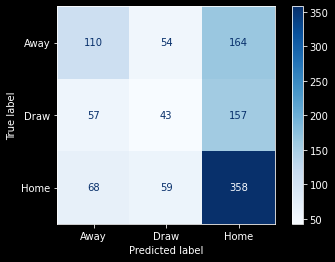

In [ ]:
# learn model with random split for train test data
trained_model_history, model = train_model(X_train_scaled,
                                           y_train,
                                           number_of_epochs=15)
pred_train, pred_test = print_accuracy(X_train_scaled, y_train, X_test_scaled, y_test, model)
y_test_res, y_pred = get_predictions(pred_test, y_test)
print_confusion_matrix(y_test_res, y_pred)

#### test first NN with last season data

In [ ]:
# split train test data to predict one season
# take the last 306 - 10*9 datapoints (because first 10 Matches are needed for the form)

X_train_s_2022, X_test_s_2022 = X.iloc[:-216], X.iloc[-216:]
y_train_s_2022, y_test_s_2022 = y[:-216], y[-216:]
match_data_bl_wo_nan_s_2022 = match_data_bl_wo_nan.iloc[-216:]

Epoch 1/15
95/95 [==============================] - 1s 2ms/step - loss: 2.3843 - accuracy: 0.4130
Epoch 2/15
95/95 [==============================] - 0s 2ms/step - loss: 1.2455 - accuracy: 0.4673
Epoch 3/15
95/95 [==============================] - 0s 2ms/step - loss: 1.1235 - accuracy: 0.4749
Epoch 4/15
95/95 [==============================] - 0s 2ms/step - loss: 1.1292 - accuracy: 0.4593
Epoch 5/15
95/95 [==============================] - 0s 2ms/step - loss: 1.1025 - accuracy: 0.4851
Epoch 6/15
95/95 [==============================] - 0s 2ms/step - loss: 1.0546 - accuracy: 0.4864
Epoch 7/15
95/95 [==============================] - 0s 2ms/step - loss: 1.0548 - accuracy: 0.4871
Epoch 8/15
95/95 [==============================] - 0s 2ms/step - loss: 1.0278 - accuracy: 0.4997
Epoch 9/15
95/95 [==============================] - 0s 2ms/step - loss: 1.0450 - accuracy: 0.4940
Epoch 10/15
95/95 [==============================] - 0s 2ms/step - loss: 1.0251 - accuracy: 0.4993
Epoch 11/15
95/95 [

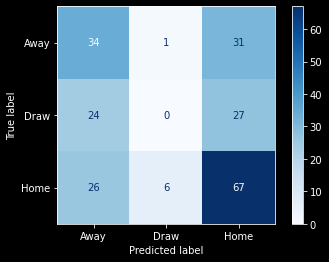

In [ ]:
# train model and get results for one season predictions 
y_train_s_2022, y_test_s_2022 = one_hot_encode_outputs(y_train_s_2022, y_test_s_2022)
trained_model_history_s_2022, model_s_2022 = train_model(X_train_s_2022, y_train_s_2022, number_of_epochs=15)
pred_train_s_2022, pred_test_s_2022 = print_accuracy(X_train_s_2022, y_train_s_2022, X_test_s_2022, y_test_s_2022, model_s_2022)
y_test_res_s_2022, y_pred_s_2022 = get_predictions(pred_test_s_2022, y_test_s_2022)
print_confusion_matrix(y_test_res_s_2022, y_pred_s_2022)

In [ ]:
# split train test data to predict one season
# take the last 306 - 10*9 datapoints (because first 10 Matches are needed for the form)

X_train_s_2022_scaled, X_test_s_2022_scaled = X_scaled[:-216], X_scaled[-216:]
y_train_s_2022, y_test_s_2022 = y[:-216], y[-216:]
match_data_bl_wo_nan_s_2022 = match_data_bl_wo_nan.iloc[-216:]

In [ ]:
# combine match data for season 22 with predictions for season 2022 for betting strategy
match_data_bl_wo_nan_s_2022.loc[:,('predictedResults')] = y_pred_s_2022

In [ ]:
# save results in dataframe
df_season_2022_percentage_res = pd.DataFrame(pred_test_s_2022, columns=('ProbAwayWin', 'ProbDraw', 'ProbHomeWin'), index=match_data_bl_wo_nan_s_2022.index)
match_data_bl_wo_nan_s_2022.loc[:, ('ProbAwayWin', 'ProbDraw', 'ProbHomeWin')] = df_season_2022_percentage_res

## Hyperparametertuning: Train second NN

In [ ]:

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten())
    # model.add(layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=128), activation=hp.Choice("activation", ["relu", "tanh"]),
    #  input_dim=n_cols_2))
    for i in range(hp.Int('layers', 2, 6)):
        model.add(keras.layers.Dense(
            units=hp.Int('units_' + str(i), 20, 100, step=10),
            activation=hp.Choice('act_' + str(i), ['relu', 'sigmoid'])))
    model.add(keras.layers.Dense(3, activation='softmax'))
    model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=4,
    directory='models_of_random_search',
    project_name='data_exploration'
)

# tuner.search_space_summary()

# will trigger exit if path already exist and summarize informtion of the path
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Trial 20 Complete [00h 00m 22s]
val_accuracy: 0.5114486068487167

Best val_accuracy So Far: 0.5221962630748749
Total elapsed time: 00h 07m 08s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in models_of_random_search\data_exploration
Showing 10 best trials
Trial summary
Hyperparameters:
layers: 3
units_0: 70
act_0: sigmoid
units_1: 90
act_1: sigmoid
units_2: 20
act_2: sigmoid
units_3: 80
act_3: relu
units_4: 90
act_4: relu
Score: 0.5221962630748749
Trial summary
Hyperparameters:
layers: 5
units_0: 50
act_0: sigmoid
units_1: 100
act_1: sigmoid
units_2: 100
act_2: sigmoid
units_3: 80
act_3: sigmoid
units_4: 20
act_4: relu
Score: 0.5210280418395996
Trial summary
Hyperparameters:
layers: 4
units_0: 60
act_0: sigmoid
units_1: 90
act_1: relu
units_2: 90
act_2: relu
units_3: 90
act_3: sigmoid
units_4: 80
act_4: relu
Score: 0.5207943767309189
Trial summary
Hyperparameters:
layers: 5
units_0: 70
act_0: sigmoid
units_1: 40
act_1: sigmoid
units_2: 30
act_2: sigmoid
units_3: 60
act_3: relu
units_4: 60
act_4: sigmoid
Score: 0.5198598057031631
Trial summary
Hyperparameters:
layers: 4
units_0: 30
act_0: sigmoid
units_1: 70
act_1: relu
units_2: 60
act_2: relu
unit

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=4,
    directory='models_of_random_search_2',
    project_name='data_exploration'
)

# tuner.search_space_summary()

# will trigger exit if path already exist and summarize informtion of the path
tuner.search(X_train_scaled, y_train, epochs=20, validation_data=(X_test_scaled, y_test))

Trial 20 Complete [00h 00m 28s]
val_accuracy: 0.5193925052881241

Best val_accuracy So Far: 0.5205607265233994
Total elapsed time: 00h 07m 33s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in models_of_random_search_2\data_exploration
Showing 10 best trials
Trial summary
Hyperparameters:
layers: 3
units_0: 80
act_0: sigmoid
units_1: 40
act_1: sigmoid
units_2: 30
act_2: sigmoid
units_3: 90
act_3: relu
units_4: 40
act_4: sigmoid
units_5: 70
act_5: relu
Score: 0.5205607265233994
Trial summary
Hyperparameters:
layers: 6
units_0: 40
act_0: sigmoid
units_1: 40
act_1: sigmoid
units_2: 30
act_2: sigmoid
units_3: 60
act_3: sigmoid
units_4: 90
act_4: relu
units_5: 20
act_5: relu
Score: 0.520327091217041
Trial summary
Hyperparameters:
layers: 5
units_0: 20
act_0: sigmoid
units_1: 70
act_1: sigmoid
units_2: 50
act_2: relu
units_3: 100
act_3: sigmoid
units_4: 100
act_4: sigmoid
units_5: 70
act_5: sigmoid
Score: 0.5193925052881241
Trial summary
Hyperparameters:
layers: 3
units_0: 50
act_0: relu
units_1: 100
act_1: sigmoid
units_2: 80
act_2: sigmoid
units_3: 90
act_3: relu
Score: 0.5189252346754074
Trial summary
Hyperparameters:
layers: 5
units_0: 50
act_0: relu

In [ ]:
# split train test data to predict one season
# take the last 306 - 10*9 datapoints (because first 10 Matches are needed for the form)

X_train_s_2022, X_test_s_2022 = X.iloc[:-216], X.iloc[-216:]
y_train_s_2022, y_test_s_2022 = y[:-216], y[-216:]
match_data_bl_wo_nan_s_2022 = match_data_bl_wo_nan.iloc[-216:]
y_train_s_2022, y_test_s_2022 = one_hot_encode_outputs(y_train_s_2022, y_test_s_2022)

In [ ]:
def train_model(X_train, y_train, number_of_epochs: int = 20, validation_data=None):
    # create model
    model = Sequential()

    # get number of columns in training data
    n_cols_2 = X_train.shape[1]
    print(n_cols_2)
    y = to_categorical(y_train)
    # add layers to model
    model.add(Dense(80, activation='sigmoid', input_dim=n_cols_2))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(70, activation='sigmoid'))
    model.add(Dense(3, activation='softmax'))

    # compile model using accuracy to measure model performance
    # model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy', 'mse'], metrics=['accuracy'])
    model.compile(metrics=['accuracy'], optimizer='adam', 
                loss='binary_crossentropy')
    # K.set_value(model.optimizer.learning_rate, 0.01)

    # early_stopping_monitor = EarlyStopping(patience=3)

    # es = callbacks.EarlyStopping(monitor='val_loss', 
    #                                    mode='min',
    #                                    patience=10, 
    #                                    restore_best_weights=True) 

    if validation_data is None:
        history = model.fit(X_train, y_train, epochs=number_of_epochs, validation_split=0.3)
    else:
        history = model.fit(X_train, y_train, epochs=number_of_epochs, validation_data=validation_data) #, callbacks=[early_stopping_monitor]) #callbacks=[es],
    return model, history

In [ ]:
model_season_2022, history_season_2022 = train_model(X_train_s_2022, y_train_s_2022, number_of_epochs=20, validation_data=(X_test_s_2022, y_test_s_2022))

9
Epoch 1/20
95/95 [==============================] - 1s 5ms/step - loss: 0.6240 - accuracy: 0.4573 - val_loss: 0.6038 - val_accuracy: 0.4954
Epoch 2/20
95/95 [==============================] - 0s 3ms/step - loss: 0.5960 - accuracy: 0.5096 - val_loss: 0.6044 - val_accuracy: 0.4954
Epoch 3/20
95/95 [==============================] - 0s 3ms/step - loss: 0.5939 - accuracy: 0.5043 - val_loss: 0.6051 - val_accuracy: 0.4861
Epoch 4/20
95/95 [==============================] - 0s 3ms/step - loss: 0.5935 - accuracy: 0.5066 - val_loss: 0.6096 - val_accuracy: 0.4630
Epoch 5/20
95/95 [==============================] - 0s 3ms/step - loss: 0.5898 - accuracy: 0.5159 - val_loss: 0.6047 - val_accuracy: 0.4907
Epoch 6/20
95/95 [==============================] - 0s 3ms/step - loss: 0.5895 - accuracy: 0.5106 - val_loss: 0.6109 - val_accuracy: 0.4769
Epoch 7/20
95/95 [==============================] - 0s 3ms/step - loss: 0.5887 - accuracy: 0.5149 - val_loss: 0.6088 - val_accuracy: 0.4722
Epoch 8/20
95/95 [

In [ ]:
model_random, history_season_random = train_model(X, to_categorical(y), number_of_epochs=20)

9
Epoch 1/20
71/71 [==============================] - 1s 5ms/step - loss: 0.6089 - accuracy: 0.4687 - val_loss: 0.6001 - val_accuracy: 0.5185
Epoch 2/20
71/71 [==============================] - 0s 3ms/step - loss: 0.5983 - accuracy: 0.4969 - val_loss: 0.6012 - val_accuracy: 0.5093
Epoch 3/20
71/71 [==============================] - 0s 3ms/step - loss: 0.5950 - accuracy: 0.5057 - val_loss: 0.6024 - val_accuracy: 0.4907
Epoch 4/20
71/71 [==============================] - 0s 2ms/step - loss: 0.5950 - accuracy: 0.5031 - val_loss: 0.6002 - val_accuracy: 0.5000
Epoch 5/20
71/71 [==============================] - 0s 2ms/step - loss: 0.5938 - accuracy: 0.4956 - val_loss: 0.5993 - val_accuracy: 0.5062
Epoch 6/20
71/71 [==============================] - 0s 2ms/step - loss: 0.5925 - accuracy: 0.5004 - val_loss: 0.5985 - val_accuracy: 0.5175
Epoch 7/20
71/71 [==============================] - 0s 2ms/step - loss: 0.5927 - accuracy: 0.5049 - val_loss: 0.6000 - val_accuracy: 0.5165
Epoch 8/20
71/71 [

In [ ]:
# history = history_season_random
history = history_season_2022
# model = model_random
model = model_season_2022

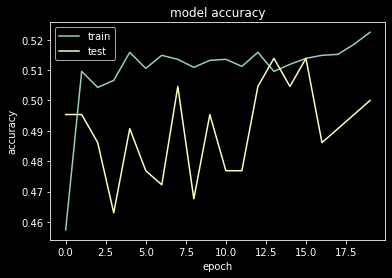

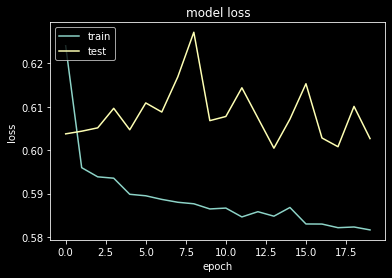

In [ ]:
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# predict last season and store result in a file

data = model.predict(X_test_s_2022)
predicted_data_random_results, test_result = get_predictions(data, data)
predicted_data_random = pd.DataFrame(data, columns=('ProbAwayWin', 'ProbDraw', 'ProbHomeWin'), index=match_data_bl_wo_nan_s_2022.index)
match_data_bl_wo_nan_s_2022.loc[:, ('ProbAwayWin', 'ProbDraw', 'ProbHomeWin')] = predicted_data_random
match_data_bl_wo_nan_s_2022.loc[:, ('predictedResults')] = predicted_data_random_results
match_data_bl_wo_nan_s_2022.to_csv("Data\\match_data_bl_test_notebook_2022.csv")